In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

#import wot
import scanpy as sc
import scvelo as scv
import cellrank as cr
import anndata as ad
from cellrank.external.kernels import WOTKernel
from cellrank.estimators import GPCCA
#from tueplots import bundles
#from tueplots import axes


In [2]:
cr.logging.print_versions()

cellrank==1.5.1+g525b847 scanpy==1.9.1 anndata==0.8.0 numpy==1.23.5 numba==0.56.4 scipy==1.10.0 pandas==1.5.2 pygpcca==1.0.4 scikit-learn==1.2.0 statsmodels==0.13.5 scvelo==0.2.5 pygam==0.8.0 matplotlib==3.6.2 seaborn==0.12.2


In [3]:
adata825 = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/larry_invitro/stage_4_growth_rate.h5ad")
adata85 = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/larry_invitro/stage_6_growth_rate.h5ad")
adata = ad.concat([adata825, adata85], merge = 'same')
adata.obs['state_info'] = pd.Series(adata.obs['state_info'], dtype='category')
adata

AnnData object with n_obs × n_vars = 44664 × 23420
    obs: 'Library', 'Cell barcode', 'time_info', 'Starting population', 'state_info', 'Well', 'SPRING-x', 'SPRING-y', 'prolif', 'apoptosis', 'growth_rate', 'scaled_growth_rate', 'scaled3_growth_rate', 'scaled4_growth_rate'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_clone', 'X_emb', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [4]:
wk = WOTKernel(adata, time_key="time_info")
wk.compute_initial_growth_rates(organism="mouse", key_added="growth_rate_init")
wk.compute_transition_matrix(
    growth_iters=3, growth_rate_key="growth_rate_init"
)

100%|██████████████████████████████████████████████████████████████████████████| 1/1 [1:09:13<00:00, 4153.37s/time pair]


WOTKernel[n=44664, cost_matrices=None, lambda1=1, lambda2=50, epsilon=0.05, growth_iters=3, solver='duality_gap', growth_rate_key='growth_rate_init', threshold='auto', self_transitions='connectivities']

In [5]:
g = GPCCA(wk)

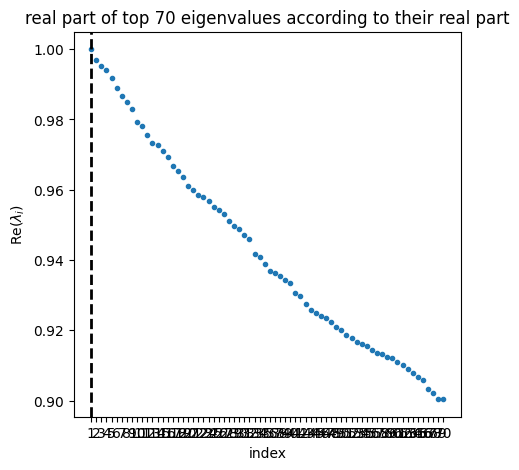

In [6]:
g.compute_schur(n_components=70)
g.plot_spectrum(real_only=True)

In [ ]:
g.compute_macrostates(n_states=55, cluster_key="state_info")
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

In [ ]:
g.compute_macrostates(n_states=9, cluster_key="state_info")
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

In [ ]:
g.set_terminal_states_from_macrostates(
    [
        "Acinar_1", "Acinar_2", "Ductal_1", "Ductal_2", "Alpha", "Beta", "Delta", "Epsilon", 
    ]
)
g.compute_absorption_probabilities(solver="gmres", use_petsc=True, tol=1e-12, preconditioner='ilu', time_to_absorption='all')
g.plot_absorption_probabilities(same_plot=False, basis="umap", perc=[0, 99], ncols=2)

In [ ]:
cr.pl.aggregate_absorption_probabilities(
    adata,
    mode='heatmap',
    lineages=["Acinar_1", "Acinar_2", "Ductal_1", "Ductal_2", "Alpha", "Beta", "Delta", "Epsilon"],
    cluster_key='celltype',
    clusters=['Acinar', 'Multipotent', 'Tip', 'Ductal', 'Ngn3 High early', 'Ngn3 High late', 'Fev+ Alpha', 'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon'],
    figsize=(17, 7),
    title="",
    #save="transprobs_wot.png"
)